## Modules dan Packages

In [1]:
!pip -q install sastrawi

In [2]:
!pip -q install nltk

In [4]:
!pip install matplotlib

     ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
     ---------------------------------------- 0.1/7.6 MB 1.7 MB/s eta 0:00:05
     - -------------------------------------- 0.2/7.6 MB 1.7 MB/s eta 0:00:05
     - -------------------------------------- 0.3/7.6 MB 1.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.4/7.6 MB 1.9 MB/s eta 0:00:04
     -- ------------------------------------- 0.5/7.6 MB 1.6 MB/s eta 0:00:05
     -- ------------------------------------- 0.5/7.6 MB 1.5 MB/s eta 0:00:05
     -- ------------------------------------- 0.5/7.6 MB 1.5 MB/s eta 0:00:05
     -- ------------------------------------- 0.5/7.6 MB 1.5 MB/s eta 0:00:05
     -- ------------------------------------- 0.6/7.6 MB 1.1 MB/s eta 0:00:07
     -- ------------------------------------- 0.6/7.6 MB 1.0 MB/s eta 0:00:08
     --- ------------------------------------ 0.6/7.6 MB 990.5 kB/s eta 0:00:08
     --- ------------------------------------ 0.7/7.6 MB 1.1 MB/s eta

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

import re
import nltk
nltk.download('stopwords')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

import random
from joblib import dump

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Acquisition

In [33]:
!wget https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/Twitter_Emotion_Dataset.csv

--2023-05-12 12:54:40--  https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/Twitter_Emotion_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 840964 (821K) [text/plain]
Saving to: ‘Twitter_Emotion_Dataset.csv’

Twitter_Emotion_Dat 100%[===================>] 821.25K  --.-KB/s    in 0.009s  

2023-05-12 12:54:40 (91.6 MB/s) - ‘Twitter_Emotion_Dataset.csv’ saved [840964/840964]



In [34]:
!wget https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/kamus_singkatan.csv

--2023-05-12 12:54:42--  https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/kamus_singkatan.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18911 (18K) [text/plain]
Saving to: ‘kamus_singkatan.csv’

kamus_singkatan.csv 100%[===================>]  18.47K  --.-KB/s    in 0s      

2023-05-12 12:54:43 (76.4 MB/s) - ‘kamus_singkatan.csv’ saved [18911/18911]



In [ ]:
data = pd.read_csv('Twitter_Emotion_Dataset.csv')
data.head()

,label,tweet
0,anger,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,anger,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,happy,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
3,anger,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
4,happy,"Sharing pengalaman aja, kemarin jam 18.00 bata..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4401 non-null   object
 1   tweet   4401 non-null   object
dtypes: object(2)
memory usage: 68.9+ KB


In [ ]:
data['label'].unique()

array(['anger', 'happy', 'sadness', 'love', 'fear'], dtype=object)

## Exploratory Data Analysis (EDA)

In [ ]:
print('Total Jumlah data:', data.shape[0], 'data\n')
print('terdiri dari (label):')
pd.value_counts(data.label)

Total Jumlah data: 4401 data

terdiri dari (label):


anger      1101
happy      1017
sadness     997
fear        649
love        637
Name: label, dtype: int64

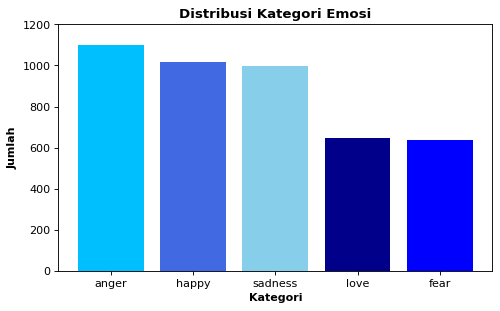

In [ ]:
height = data['label'].value_counts()
labels = ('anger', 'happy', 'sadness', 'love', 'fear')
y_pos  = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,1200)
plt.title('Distribusi Kategori Emosi', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue', 'darkblue', 'blue'])
plt.xticks(y_pos, labels)
plt.show()

## Text Preprocessing

### Case Folding

In [ ]:
def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [ ]:
raw_sample   = data['tweet'].iloc[5]
case_folding = text_preprocessing(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Dari sekian banyak thread yang aku baca, thread ini paling aneh sih dalam penulisan. Sumpah aneh bgt, mau ngatain "lebay" aja segala bikin thread hadeh. Aku juga ga jago nulis, tapi tulisan aku ga seberantakan thread mbaknya.
Case folding	:  dari sekian banyak thread yang aku baca thread ini paling aneh sih dalam penulisan sumpah aneh bgt mau ngatain lebay aja segala bikin thread hadeh aku juga ga jago nulis tapi tulisan aku ga seberantakan thread mbaknya


### Word Normalization

In [ ]:
df = pd.read_csv('kamus_singkatan.csv', header=None, sep = ';')
df[1] = df[1].str.strip()
lst = df.values.tolist()
kamus = [tuple(x) for x in lst]
print(kamus)

[('aamiin', 'amin'), ('adek', 'adik'), ('adlh', 'adalah'), ('aer', 'air'), ('aiskrim', 'es krim'), ('aj', 'saja'), ('aja', 'saja'), ('ajah', 'saja'), ('ajalah', 'saja'), ('aje', 'saja'), ('ajh', 'saja'), ('ajh', 'saja'), ('ajj', 'saja'), ('aku', 'saya'), ('ak', 'saya'), ('akoh', 'saya'), ('akutu', 'saya'), ('aq', 'saya'), ('alesan', 'alasan'), ('ama', 'sama'), ('amaca', 'ah masa'), ('amuh', 'kamu'), ('ancur', 'hancur'), ('ane', 'saya'), ('anget', 'hangat'), ('anjeng', 'anjing'), ('ank', 'anak'), ('apah', 'apa'), ('aph', 'apa'), ('apo', 'apa'), ('apose', 'apa'), ('apz', 'apa'), ('aq', 'saya'), ('artine', 'artinya'), ('asek', 'asik'), ('ati2', 'hati-hati'), ('atit', 'sakit'), ('atu', 'satu'), ('atw', 'atau'), ('ayang', 'sayang'), ('ayuk', 'ayo'), ('babang', 'abang'), ('bae', 'baik'), ('bais', 'habis'), ('bakalan', 'akan'), ('bales', 'balas'), ('bandingin', 'bandingkan'), ('banget', 'sekali'), ('bangett', 'sangat'), ('banyakin', 'perbanyak'), ('barengan', 'bersamaan'), ('baryaw', 'sabar y

In [ ]:
def clean(kata):
  if any(kata in (match := term) for term in kamus):
    return kamus[kamus.index(match)][1]
  else:
    return kata

### Filtering (Stopword Removal)

In [ ]:
stopwords_ind = stopwords.words('indonesian')

In [ ]:
len(stopwords_ind)

758

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [ ]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['tsel', 'gb', 'rb']                    # Tambahkan kata dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [ ]:
raw_sample       = data['tweet'].iloc[5]
case_folding     = text_preprocessing(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Dari sekian banyak thread yang aku baca, thread ini paling aneh sih dalam penulisan. Sumpah aneh bgt, mau ngatain "lebay" aja segala bikin thread hadeh. Aku juga ga jago nulis, tapi tulisan aku ga seberantakan thread mbaknya.
Case folding		:  dari sekian banyak thread yang aku baca thread ini paling aneh sih dalam penulisan sumpah aneh bgt mau ngatain lebay aja segala bikin thread hadeh aku juga ga jago nulis tapi tulisan aku ga seberantakan thread mbaknya
Stopword removal	:  sekian thread baca thread aneh sih penulisan sumpah aneh bgt ngatain lebay aja bikin thread hadeh ga jago nulis tulisan ga seberantakan thread mbaknya


### Stemming

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
def LemTokens(tokens):
    return [clean(token) for token in tokens]
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower()))

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
detokenizer = Detok()
def Detoken(kata):
  text = detokenizer.detokenize(kata)
  text = re.sub('\s*,\s*', ', ', text)
  text = re.sub('\s*\.\s*', '. ', text)
  text = re.sub('\s*\?\s*', '? ', text)
  return text

In [ ]:
raw_sample       = data['tweet'].iloc[4]
case_folding     = text_preprocessing(raw_sample)
sent_tokens = nltk.sent_tokenize(case_folding)# converts to list of sentences 
word_tokens = nltk.word_tokenize(case_folding)# converts to list of words
kalimat = LemNormalize(case_folding)
normal = Detoken(kalimat)
stopword_removal = remove_stop_words(normal)
text_stemming    = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Normalisasi\t\t: ', normal)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Sharing pengalaman aja, kemarin jam 18.00 batalin tiket di stasiun pasar senen, lancar, antrian tidak terlalu rame,15 menitan dan beress semua! Mungkin bisa dicoba twips, di jam-jam segitu  cc [USERNAME]
Case folding		:  sharing pengalaman aja kemarin jam  batalin tiket di stasiun pasar senen lancar antrian tidak terlalu rame menitan dan beress semua mungkin bisa dicoba twips di jamjam segitu  cc username
Normalisasi		:  sharing pengalaman saja kemarin jam batalin tiket di stasiun pasar senin lancar antrian tidak terlalu ramai menitan dan beress semua mungkin bisa dicoba twips di jamjam segitu cc username
Stopword removal	:  sharing pengalaman kemarin jam batalin tiket stasiun pasar senin lancar antrian ramai menitan beress dicoba twips jamjam segitu cc username
Stemming		:  sharing alam kemarin jam batalin tiket stasiun pasar senin lancar antri ramai menit beress coba twips jamjam segitu cc username


### Text Preprocessing Pipeline

In [ ]:
def text_preprocessing_process(kalimat):
  kalimat = text_preprocessing(kalimat)
  sent_tokens = nltk.sent_tokenize(kalimat)# converts to list of sentences 
  word_tokens = nltk.word_tokenize(kalimat)# converts to list of words
  kalimat = LemNormalize(kalimat)
  kalimat = Detoken(kalimat)
  kalimat = remove_stop_words(kalimat)
  kalimat = stemming(kalimat)
  return kalimat

In [ ]:
%%time
data['clean_teks'] = data['tweet'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 23min 46s, sys: 3.97 s, total: 23min 50s
Wall time: 24min 8s


In [ ]:
data['label'].unique()

array(['anger', 'happy', 'sadness', 'love', 'fear'], dtype=object)

In [ ]:
ganti_label = {'anger': 0, 'happy': 1, 'sadness': 2, 'love': 3, 'fear': 4}

In [ ]:
data['label'] = data['label'].replace(ganti_label)

In [ ]:
data['label'].unique()

array([0, 1, 2, 3, 4])

In [ ]:
data

,label,tweet,clean_teks
0,0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",jalan jatibarupolisi gertak gubernur emangny p...
1,0,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",cewek lho kayak rasain sibuk jaga rasain sakit...
2,1,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj amad foto google s...
3,0,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",jalan jatibarubagian wilayah tn abangpengatura...
4,1,"Sharing pengalaman aja, kemarin jam 18.00 bata...",sharing alam kemarin jam batalin tiket stasiun...
...,...,...,...
4396,3,"Tahukah kamu, bahwa saat itu papa memejamkan m...",tahu papa mejam mata tahan gejolak batin papa ...
4397,4,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,sulit tetap calon wapresnya jokowi pilpres sal...
4398,0,"5. masa depannya nggak jelas. lha iya, gimana ...",depan lha iya gimana coba lulus seni bisa nari...
4399,1,[USERNAME] dulu beneran ada mahasiswa Teknik U...,username mahasiswa teknik ui nembak pacar pas ...


In [6]:
data = data[["clean_teks", "label"]]

NameError: name 'data' is not defined

In [ ]:
data

,clean_teks,label
0,jalan jatibarupolisi gertak gubernur emangny p...,0
1,cewek lho kayak rasain sibuk jaga rasain sakit...,0
2,kepingin gudeg mbarek bu hj amad foto google s...,1
3,jalan jatibarubagian wilayah tn abangpengatura...,0
4,sharing alam kemarin jam batalin tiket stasiun...,1
...,...,...
4396,tahu papa mejam mata tahan gejolak batin papa ...,3
4397,sulit tetap calon wapresnya jokowi pilpres sal...,4
4398,depan lha iya gimana coba lulus seni bisa nari...,0
4399,username mahasiswa teknik ui nembak pacar pas ...,1


In [7]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

NameError: name 'data' is not defined

## Modifikasi

In [36]:
data = pd.read_csv('clean_data.csv')
data = data[["clean_teks", "label"]]
data.head()

,clean_teks,label
0,jalan jatibarupolisi gertak gubernur emangny p...,0
1,cewek lho kayak rasain sibuk jaga rasain sakit...,0
2,kepingin gudeg mbarek bu hj amad foto google s...,1
3,jalan jatibarubagian wilayah tn abangpengatura...,0
4,sharing alam kemarin jam batalin tiket stasiun...,1


## Feature Engineering

In [37]:
# Pisahkan kolom feature dan target
X = data['clean_teks']
y = data['label']

In [38]:
X

0       jalan jatibarupolisi gertak gubernur emangny p...
1       cewek lho kayak rasain sibuk jaga rasain sakit...
2       kepingin gudeg mbarek bu hj amad foto google s...
3       jalan jatibarubagian wilayah tn abangpengatura...
4       sharing alam kemarin jam batalin tiket stasiun...
                              ...                        
4396    tahu papa mejam mata tahan gejolak batin papa ...
4397    sulit tetap calon wapresnya jokowi pilpres sal...
4398    depan lha iya gimana coba lulus seni bisa nari...
4399    username mahasiswa teknik ui nembak pacar pas ...
4400           ya allah engkau sakit hati sembuh ya allah
Name: clean_teks, Length: 4401, dtype: object

In [39]:
y

0       0
1       0
2       1
3       0
4       1
       ..
4396    3
4397    4
4398    0
4399    1
4400    2
Name: label, Length: 4401, dtype: int64

### Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [40]:
tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [41]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names()))

14063


In [42]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names())

['aa', 'aaa', 'aaaaaa', 'aaaaaaa', 'aaaaaaaaa', 'aaaaak', 'aaaahhh', 'aaah', 'aaahhhh', 'aaamiiinnn', 'aah', 'aahhseeeek', 'aalamiin', 'aamiiin', 'aatu', 'abad', 'abadi', 'abah', 'abai', 'abal', 'abalnya', 'abang', 'abangpengaturan', 'abar', 'abatyg', 'abb', 'abdi', 'abdul', 'abel', 'abg', 'abgmu', 'abi', 'abiiiss', 'abis', 'abistu', 'able', 'abng', 'abon', 'about', 'abs', 'absen', 'absurb', 'absurd', 'abu', 'abuabu', 'abud', 'abuse', 'ac', 'acak', 'acar', 'acara', 'acc', 'accept', 'accompany', 'accomplished', 'according', 'accoun', 'account', 'accounting', 'ace', 'aceh', 'acha', 'acong', 'acoount', 'action', 'actor', 'actually', 'acu', 'acuh', 'ad', 'ada', 'adaa', 'adaaa', 'adaaaa', 'adab', 'adabyu', 'adain', 'adaka', 'adakan', 'adam', 'adapakah', 'adaptasi', 'adat', 'adatjawa', 'addeh', 'addict', 'addicted', 'ade', 'adegan', 'adekan', 'adekgemas', 'adekku', 'adem', 'adhe', 'adi', 'adidas', 'adie', 'adik', 'adil', 'adiluhung', 'adimas', 'adipati', 'adit', 'aditama', 'aditia', 'adl', '

In [43]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names())
data_tf_idf

,aa,aaa,aaaaaa,aaaaaaa,aaaaaaaaa,aaaaak,aaaahhh,aaah,aaahhhh,aaamiiinnn,...,zmn,zohri,zon,zona,zonasi,zonk,zonkies,zonknya,zuhri,zulkifli
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

### Feature Selection

In [46]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [47]:
# Ten features with highest chi-squared statistics are selected 
chi2_features    = SelectKBest(chi2, k=10000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 14063
Reduced feature number: 10000


In [48]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,1.770212
1,0.799492
2,0.949625
3,1.066105
4,1.266647
...,...
14058,0.566629
14059,0.811375
14060,1.622252
14061,0.854418


In [49]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,1.770212,aa
1,0.799492,aaa
2,0.949625,aaaaaa
3,1.066105,aaaaaaa
4,1.266647,aaaaaaaaa
...,...,...
14058,0.566629,zonk
14059,0.811375,zonkies
14060,1.622252,zonknya
14061,0.854418,zuhri


In [50]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
2189,318.442269,cinta
12341,249.548082,takut
11068,208.001490,sayang
11459,81.878098,seram
8680,67.558420,ngeri
...,...,...
12905,0.078559,tipe
1183,0.067521,be
11169,0.058963,sedap
2369,0.058607,cuek


In [51]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([ True, False,  True, ...,  True, False, False])

In [52]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aa',
 'aaaaaa',
 'aaaaaaa',
 'aaaaaaaaa',
 'aaaaak',
 'aaahhhh',
 'aaamiiinnn',
 'aah',
 'aahhseeeek',
 'aalamiin',
 'aamiiin',
 'abah',
 'abai',
 'abal',
 'abalnya',
 'abar',
 'abdul',
 'abel',
 'abg',
 'abgmu',
 'abi',
 'abiiiss',
 'abis',
 'abistu',
 'abon',
 'about',
 'abs',
 'absen',
 'absurb',
 'absurd',
 'abu',
 'abuabu',
 'abud',
 'ac',
 'acak',
 'acar',
 'acara',
 'acc',
 'accept',
 'accomplished',
 'according',
 'account',
 'accounting',
 'acha',
 'acong',
 'acoount',
 'action',
 'actor',
 'actually',
 'ad',
 'ada',
 'adaaa',
 'adaaaa',
 'adab',
 'adabyu',
 'adain',
 'adaka',
 'adakan',
 'adapakah',
 'adaptasi',
 'adatjawa',
 'addicted',
 'ade',
 'adegan',
 'adekan',
 'adekgemas',
 'adekku',
 'adem',
 'adhe',
 'adi',
 'adie',
 'adimas',
 'adipati',
 'adit',
 'aditama',
 'aditia',
 'admin',
 'adminnyaaa',
 'admire',
 'adoeh',
 'adore',
 'adu',
 'aduh',
 'aduhaduh',
 'aduuu',
 'adventure',
 'advokat',
 'af',
 'afdol',
 'afganistan',
 'afs',
 'after',
 'aga',
 'againhappy',
 '

In [53]:
# Memilih fitur yang telah terseleksi dari vocabulary TF IDF
kbest_feature = {}

for (k,v) in tf_idf.vocabulary_.items():
  if k in selected_feature:
    kbest_feature[k] = v

In [54]:
len(kbest_feature)

10000

In [55]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aa,aaaaaa,aaaaaaa,aaaaaaaaa,aaaaak,aaahhhh,aaamiiinnn,aah,aahhseeeek,aalamiin,...,zein,zeratu,zero,zha,zhon,zidanelhadadi,zina,zon,zona,zonknya
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

## Modelling (Machine Learning)

In [57]:
# Memisihkan data training dan data testing dengan perbandingan 80:20
X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=0)

In [58]:
# Training Model
algorithm = MultinomialNB()
model     = algorithm.fit(X_train, y_train)

## Prediction

In [59]:
# Prediksi untuk Data Latih
predicted_train = model.predict(X_train)

# hasil ini akan kita bandingkan dengan nilai y_train (labeling dari manusia)
predicted_train[1:20]

array([2, 1, 0, 1, 0, 4, 0, 1, 0, 1, 0, 2, 1, 1, 0, 2, 0, 2, 2],
      dtype=int64)

In [60]:
# Prediksi untuk Data Uji
predicted_test = model.predict(X_test)

# hasil ini akan kita bandingkan dengan nilai y_test (labeling dari manusia)
predicted_test[1:20]

array([2, 2, 2, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2],
      dtype=int64)

# Model Evaluation

In [61]:
# Perhitungan Performa Model untuk Data Latih
CM = confusion_matrix(y_train, predicted_train)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_train, predicted_train)*100,"%\n")

print(classification_report(y_train,predicted_train))

[[842  10  14   1   3]
 [ 34 770  18   2   1]
 [ 66  22 700   1   0]
 [ 13  55  52 382   2]
 [ 77  28  45   3 379]] 

ACCURACY	: 87.30113636363637 %

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       870
           1       0.87      0.93      0.90       825
           2       0.84      0.89      0.87       789
           3       0.98      0.76      0.86       504
           4       0.98      0.71      0.83       532

    accuracy                           0.87      3520
   macro avg       0.90      0.85      0.87      3520
weighted avg       0.88      0.87      0.87      3520



In [62]:
# Perhitungan Performa Model untuk Data Uji
CM = confusion_matrix(y_test, predicted_test)

print(CM,'\n')

print("ACCURACY\t:", accuracy_score(y_test, predicted_test)*100,"%\n")

print(classification_report(y_test,predicted_test))

[[197   7  25   0   2]
 [ 39 126  26   1   0]
 [ 49  31 123   4   1]
 [  8  42  27  56   0]
 [ 32  16  25   1  43]] 

ACCURACY	: 61.861520998864926 %

              precision    recall  f1-score   support

           0       0.61      0.85      0.71       231
           1       0.57      0.66      0.61       192
           2       0.54      0.59      0.57       208
           3       0.90      0.42      0.57       133
           4       0.93      0.37      0.53       117

    accuracy                           0.62       881
   macro avg       0.71      0.58      0.60       881
weighted avg       0.67      0.62      0.61       881



## Menyimpan Model

In [63]:
# save the model to disk
dump(model, filename="model_spam_tfidf_nb.model")

['model_spam_tfidf_nb.model']